# 511 Clustering Analysis with dataset having Length

### This notebook contains the clustering model and performance testing on the dataset of 511 work zone events. Data and features used in this clustering model can be created by running notebooks 511_00 through 511_04. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# import dataset
df_511 = pd.read_csv('../data/cleaned_data/511_crash_lion_processed_0630.csv')
df_511 = df_511.dropna()
df_511['crash_binary_900ft'] =  df_511['crash_count_900ft'].apply(lambda x: 1 if x>0 else 0)
df_511['crash_binary_1800ft'] = df_511['crash_count_1800ft'].apply(lambda x: 1 if x>0 else 0)
df_511['crash_binary_2700ft'] = df_511['crash_count_2700ft'].apply(lambda x: 1 if x>0 else 0)
df_511['crash_binary_3600ft'] = df_511['crash_count_3600ft'].apply(lambda x: 1 if x>0 else 0)
df_511['create_time'] = pd.to_datetime(df_511['create_time'])
df_511 = df_511.sort_values(by='create_time')
df_511_target = df_511[['event_id',
                        'season',
                        'roadway_type',
                        'create_time_weekend',
                        'street_width',
                        'posted_speed',
                        'daylight_ratio',
                        'peak_ratio',
                        'crash_binary_900ft',
                        'crash_binary_1800ft',
                        'crash_binary_2700ft',
                        'crash_binary_3600ft',
                        'geometry'
                         ]]

C:\Users\ps336\Anaconda3\envs\Python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def split_train_test_setbaseLineScore(df):
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(df, test_size=0.33, random_state = 10)
    train = train.drop(['geometry'],axis=1)
    test = test.drop(['geometry'],axis=1)
    
    prob_by_rwtype = train[['roadway_type',
                        'crash_binary_900ft',
                        'crash_binary_1800ft',
                        'crash_binary_2700ft',
                        'crash_binary_3600ft']].groupby('roadway_type').mean()
    print(prob_by_rwtype.to_markdown())
    test_df = test.copy()
    test_df['y_pred'] = test_df['roadway_type'].apply(lambda x:prob_by_rwtype.loc[x,'crash_binary_900ft'])
    
    # calculating actual value in test data
    prob_by_rwtype_test = test_df[['roadway_type',
                            'crash_binary_900ft',
                            'crash_binary_1800ft',
                            'crash_binary_2700ft',
                            'crash_binary_3600ft']].groupby('roadway_type').mean()
    test_df['y_actual'] = test_df['roadway_type'].apply(lambda x:prob_by_rwtype_test.loc[x,'crash_binary_900ft'])
    
    # this code is from https://stackoverflow.com/questions/51439892/how-to-find-symmetric-mean-absolute-error-in-python
    # smape: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    def smape(A, F):
        return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    
    smape_score = smape(test_df['y_pred'],test_df['y_actual'])
    mae_score = mean_absolute_error(test_df['y_pred'],test_df['y_actual'])
    print('900ft')
    print('SMAPE score: {}'.format(smape(test_df['y_pred'],test_df['y_actual'])))
    print('MAE score: {}'.format(mean_absolute_error(test_df['y_pred'],test_df['y_actual']))) 
    
    return train, test, smape_score, mae_score

In [3]:
def cluster_analysis_measure_performance(train_with_all_features, numerical_features, categorical_features, index):
    
    X_train = train_with_all_features.drop(['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft'], axis=1)
    y_train = train_with_all_features.loc[:, ['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft']]
    # only using the train dataset for cluster Analysis
    if index:
        X_train = X_train.set_index(index)
    
    train = X_train[numerical_features + categorical_features]
    
    # normalizing the train dataset
    train_norm = train.copy()
    
    # normalizing Numeric data
    column_names_to_normalize = numerical_features
    x = train_norm[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train_norm.index)
    train_norm[column_names_to_normalize] = df_temp
    
    #creating dummies for Categorical Variable
    train_norm = pd.get_dummies(data=train_norm, columns=categorical_features)
    
    # K-means Clustering functions
    def performKmeansClustering(df):
        X = df.copy()
        range_n_clusters = [2,3,4,5,6,7]
        # algo_name = 'KMeans'
        clustering_algo = ['KMeans']
        for algo_name in clustering_algo:
            plt.figure(figsize=(20,15))
            print("\n")
            for i, n_clusters in enumerate(range_n_clusters):

                ax = plt.subplot(230 + i +1)

                ax.set_xlim([-0.1, 1])
                ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

                if algo_name == 'KMeans':
                    model = KMeans(n_clusters=n_clusters, random_state=10)

                clusterer = model
                cluster_labels = clusterer.fit_predict(X)

                silhouette_avg = silhouette_score(X, cluster_labels)
                print("For " + algo_name + " n_clusters =", n_clusters,
                      "The average silhouette_score is :", silhouette_avg)

                sample_silhouette_values = silhouette_samples(X, cluster_labels)

                y_lower = 10
                for i in range(n_clusters):

                    ith_cluster_silhouette_values = \
                        sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax.fill_betweenx(np.arange(y_lower, y_upper),
                                      0, ith_cluster_silhouette_values,
                                      facecolor=color, edgecolor=color, alpha=0.7)

                    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    y_lower = y_upper + 10  

                ax.set_title((algo_name +  " clustering "
                              "with n_clusters = %d" % n_clusters),
                             fontsize=14)
                ax.set_xlabel("The silhouette coefficient values")
                ax.set_ylabel("Cluster label")

                ax.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax.set_yticks([])  # Clear the yaxis labels / ticks
                ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            plt.show()
            
    performKmeansClustering(train_norm)


In [14]:
def perform_Clustering_Visualization_Performance_Measurement(train_with_all_features, test, numerical_features, categorical_features, index, no_cluster):
    
    X_train = train_with_all_features.drop(['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft'], axis=1)
    y_train_norm = train_with_all_features.loc[:, ['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft']]
    
    # only using the train dataset for cluster Analysis
    if index:
        X_train = X_train.set_index(index)
    
    train = X_train[numerical_features + categorical_features]
    
    # normalizing the train dataset
    train_norm = train.copy()
    
    # normalizing Numeric data
    column_names_to_normalize = numerical_features
    x = train_norm[column_names_to_normalize].values
    x_scaled = min_max_scaler.fit_transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train_norm.index)
    train_norm[column_names_to_normalize] = df_temp
    
    #creating dummies for Categorical Variable
    train_norm = pd.get_dummies(data=train_norm, columns=categorical_features)
    
    # Trying with Number of Cluster= 6 for best Silhoutte Avg Score and normalized features
    X = train_norm.copy()
    kmodel = KMeans(n_clusters=no_cluster, random_state=10)
    cluster_labels = kmodel.fit_predict(X)
    train_norm['kmeans_cluster'] = cluster_labels
    y_train_norm['cluster'] = cluster_labels
    
    
    
    # Visualizing the Cluster stats
    print("Cluster size and distribution")
    print(train_norm.kmeans_cluster.value_counts().to_markdown())
    
    print("Visualizing the histograms for Numerical features Clusters")
    for i in range(no_cluster):
        # visualzing the clusters for Numerical features
        print("Visualizing Cluster {} Numerical features", i)
#         train_norm[train_norm.kmeans_cluster == i][[numerical_features].hist(figsize=(10,10))
#         plt.show()
    print("Visualizing the categorical features across clusters")
    Df_with_Clustering_Features_categorical = train[categorical_features]                                            
    train_with_categorical = pd.merge(train_norm, Df_with_Clustering_Features_categorical, left_index=True, right_index=True)
    for i in range(len(categorical_features)):
        print("Categorical feature - {} across Clusters".format(categorical_features[i]))
        print(train_with_categorical.groupby(['kmeans_cluster', categorical_features[i]]).size().to_markdown())
        
                                                   
    # Measure Performance
    prob_by_cluster_norm = y_train_norm.groupby('cluster').mean()
    print(prob_by_cluster_norm.to_markdown())
    X_test = test.drop(['crash_binary_900ft',
                      'crash_binary_1800ft',
                      'crash_binary_2700ft',
                      'crash_binary_3600ft'], axis=1)
    X_test_with_crash = test.copy()
    # only using the train dataset for cluster Analysis
    if index:
        X_test = X_test.set_index(index)
    
    X_test = X_test[numerical_features + categorical_features]
    X_test_with_dummies = pd.get_dummies(data=X_test, columns=categorical_features)
                                                   
    column_names_to_normalize_test = numerical_features
    x = X_test_with_dummies[column_names_to_normalize_test].values
    x_scaled = min_max_scaler.transform(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize_test, index = X_test_with_dummies.index)
    X_test_with_dummies[column_names_to_normalize_test] = df_temp
    
#     print(list(X_test_with_dummies.columns))
    clusterLabels= kmodel.predict(X_test_with_dummies)
    X_test['cluster'] = clusterLabels
    X_test_with_crash['cluster'] = clusterLabels
    
    X_test['crash_prob_900ft_pred'] = X_test['cluster'].apply(lambda x:prob_by_cluster_norm.loc[x,'crash_binary_900ft'])
    
#     Measure actual probabilities in test data by cluster
    prob_by_cluster_norm_test = X_test_with_crash.groupby('cluster').mean()
    X_test_with_crash['crash_prob_900ft_actual'] = X_test_with_crash['cluster'].apply(lambda x:prob_by_cluster_norm_test.loc[x,'crash_binary_900ft'])
                                                   
    # this code is from https://stackoverflow.com/questions/51439892/how-to-find-symmetric-mean-absolute-error-in-python
    # smape: https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    def smape(A, F):
        return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
                                                   
    smape_score = smape(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])
    mae_score = mean_absolute_error(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])                                               
    print('900 ft')
    print('SMAPE score: {}'.format(smape(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])))
    print('MAE score: {}'.format(mean_absolute_error(X_test['crash_prob_900ft_pred'],X_test_with_crash['crash_prob_900ft_actual'])))
    
    
    return train_norm, X_test_with_crash, X_test, smape_score, mae_score



In [6]:
# Assuming Input having atleast following features
# [   'event_id',
#     'season',
#     'roadway_type',
#     'create_time_weekend',
#     'street_width',
#     'posted_speed',
#     'daylight_ratio',
#     'peak_ratio',
#     'crash_binary_900ft',
#     'crash_binary_1800ft',
#     'crash_binary_2700ft',
#     'crash_binary_3600ft',
#     'geometry'
#      ]

#### Filter data for length data

In [7]:
df_with_length = pd.read_csv('clustering_2_att.csv')

In [8]:
# join the 2 df
df_511_target_with_length = pd.merge(df_511_target, df_with_length, on='event_id', how="inner")

In [9]:
df_511_target_with_length.shape

(263, 16)

In [10]:
# Call function 1 to split train test and set base line score
train, test, base_smape, base_mae = split_train_test_setbaseLineScore(df_511_target_with_length)

|   roadway_type |   crash_binary_900ft |   crash_binary_1800ft |   crash_binary_2700ft |   crash_binary_3600ft |
|---------------:|---------------------:|----------------------:|----------------------:|----------------------:|
|              1 |             0.119718 |              0.239437 |              0.387324 |              0.464789 |
|              2 |             0.193548 |              0.290323 |              0.354839 |              0.451613 |
|              3 |             0        |              0        |              0.333333 |              0.666667 |
900ft
SMAPE score: 29.375179190450126
MAE score: 0.030811491119501586




For KMeans n_clusters = 2 The average silhouette_score is : 0.28910643551489906
For KMeans n_clusters = 3 The average silhouette_score is : 0.3605756485457609
For KMeans n_clusters = 4 The average silhouette_score is : 0.3777115290539991
For KMeans n_clusters = 5 The average silhouette_score is : 0.42567752208736154
For KMeans n_clusters = 6 The average silhouette_score is : 0.4710767498743781
For KMeans n_clusters = 7 The average silhouette_score is : 0.5101003954896088


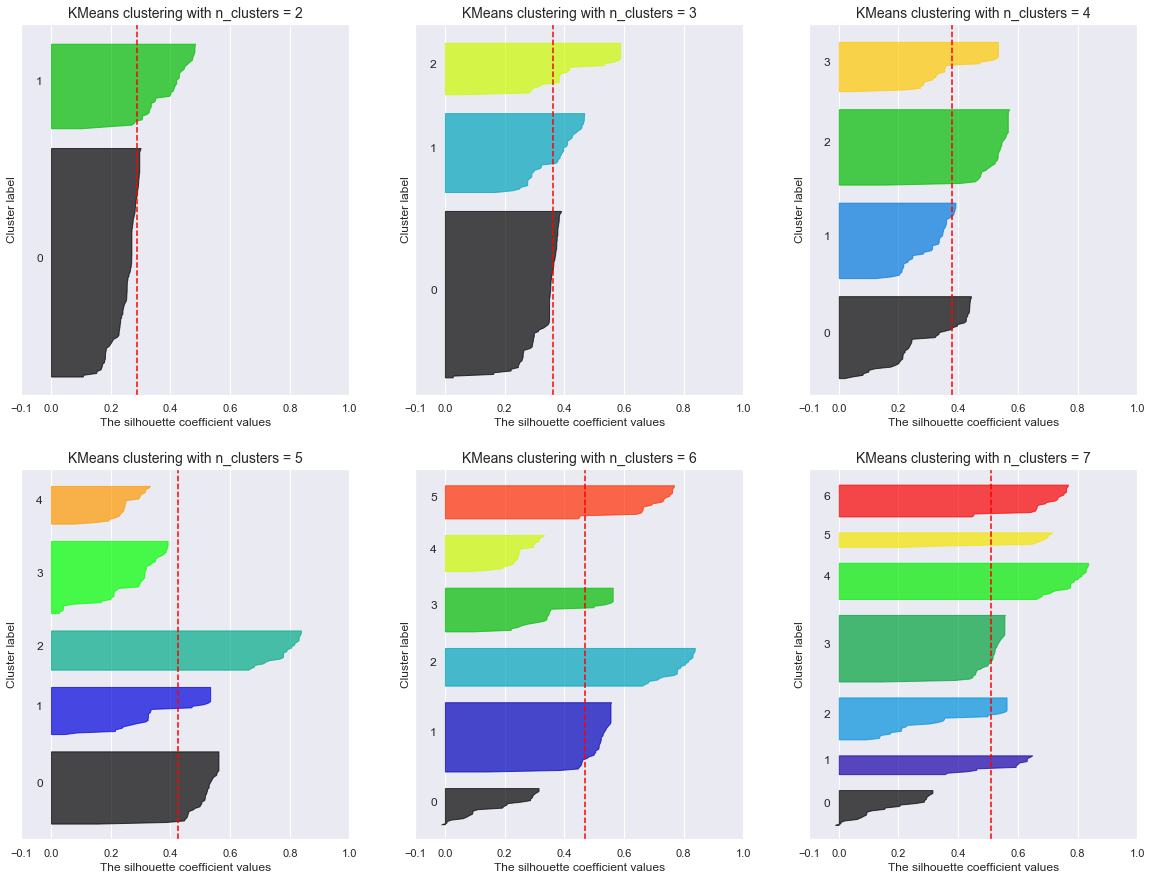

In [11]:
# Call function 2 for Cluster Analysis
numerical_features = ['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio', 'length_ft' ]
categorical_features = ['season', 'roadway_type', 'create_time_weekend']
index = 'event_id'
cluster_analysis_measure_performance(train, numerical_features, categorical_features, index)

In [15]:
# Call Function 3 to implement K-Means on train and measure performance on test
no_cluster=4
print("--------------------------------------------------------------------------------------------------------------------")
print("Performance when number of cluster are {}".format(no_cluster))
train_with_clusterlabels, test_with_clusterlabels, test_with_pred, final_smape, final_mae = perform_Clustering_Visualization_Performance_Measurement(train, test, numerical_features, categorical_features, index, no_cluster)

--------------------------------------------------------------------------------------------------------------------
Performance when number of cluster are 4
Cluster size and distribution
|    |   kmeans_cluster |
|---:|-----------------:|
|  0 |               51 |
|  2 |               47 |
|  1 |               47 |
|  3 |               31 |
Visualizing the histograms for Numerical features Clusters
Visualizing Cluster {} Numerical features 0
Visualizing Cluster {} Numerical features 1
Visualizing Cluster {} Numerical features 2
Visualizing Cluster {} Numerical features 3
Visualizing the categorical features across clusters
Categorical feature - season across Clusters
|               |   0 |
|:--------------|----:|
| (0, 'fall')   |  11 |
| (0, 'spring') |  26 |
| (0, 'winter') |  14 |
| (1, 'fall')   |   3 |
| (1, 'spring') |   7 |
| (1, 'summer') |  23 |
| (1, 'winter') |  14 |
| (2, 'summer') |  47 |
| (3, 'fall')   |   7 |
| (3, 'spring') |   2 |
| (3, 'summer') |  19 |
| (3, 'wint

#### Workzone with Cluster Labels

In [22]:
train_with_clusterlabels.head()

,posted_speed,street_width,daylight_ratio,peak_ratio,length_ft,season_fall,season_spring,season_summer,season_winter,roadway_type_1,roadway_type_2,roadway_type_3,create_time_weekend_0,create_time_weekend_1,kmeans_cluster
event_id,,,,,,,,,,,,,,,
7109,0.166667,0.178571,0.008646,0.0,0.038971,0,0,1,0,1,0,0,1,0,2
15057,0.166667,0.285714,0.000000,0.0,0.033713,0,0,1,0,1,0,0,0,1,1
8372,0.166667,0.821429,0.009709,0.0,0.206603,0,1,0,0,1,0,0,1,0,0
21592,0.166667,0.285714,0.000000,0.0,0.215278,0,1,0,0,1,0,0,1,0,0
24637,0.166667,0.285714,0.000000,0.0,0.241832,0,1,0,0,1,0,0,0,1,1


In [23]:
train_data_with_labels = train_with_clusterlabels[['length_ft','kmeans_cluster']]
train_data_with_labels = train_data_with_labels.rename({'kmeans_cluster': 'cluster'}, axis=1)

In [24]:
train_data_with_labels.head()

,length_ft,cluster
event_id,,
7109,0.038971,2
15057,0.033713,1
8372,0.206603,0
21592,0.215278,0
24637,0.241832,1


In [26]:
test_data_with_labels = test_with_clusterlabels[['event_id','length_ft','cluster']]
test_data_with_labels = test_data_with_labels.set_index('event_id')

In [27]:
test_data_with_labels.head()

,length_ft,cluster
event_id,,
16682,566.504322,3
16625,566.504322,3
4232,561.572574,2
6715,905.873470,1
5694,336.532212,0


In [28]:
data_with_labels = pd.concat([train_data_with_labels, test_data_with_labels])

In [29]:
import geopandas as gp
df_511_target_geo = gp.GeoDataFrame(df_511_target)
df_511_target_geo = df_511_target_geo.set_index('event_id')
# Adding Cluster Labels to data
df_511_target_geo_cluster = pd.merge(df_511_target_geo, data_with_labels, left_index=True, right_index=True)

## Cluster Characteristics

##### Workzone distribution across cluster

In [30]:
df_511_target_geo_cluster.cluster.value_counts()

0    81
2    68
1    61
3    53
Name: cluster, dtype: int64

##### Visualizing Numerical feature distribution for clusters

In [31]:
df_511_target_geo_cluster.head()

,season,roadway_type,create_time_weekend,street_width,posted_speed,daylight_ratio,peak_ratio,crash_binary_900ft,crash_binary_1800ft,crash_binary_2700ft,crash_binary_3600ft,geometry,length_ft,cluster
event_id,,,,,,,,,,,,,,
8701,spring,1,0,30.0,25.0,0.000000,0.0,0,0,0,1,POINT (-73.97437084640173 40.75816388281111),0.073053,0
8649,spring,1,0,35.0,25.0,0.011161,0.0,0,1,1,1,POINT (-73.97822579036053 40.75324646600973),283.042009,0
8600,spring,1,0,28.0,25.0,0.000000,0.0,0,0,1,1,POINT (-73.98901966336354 40.74231653338661),378.018151,0
8487,spring,1,0,28.0,25.0,0.007614,0.0,0,1,1,1,POINT (-74.00680222392708 40.70974387485788),0.048101,0
8448,spring,1,0,60.0,25.0,0.000000,0.0,0,1,1,1,POINT (-73.98727323860646 40.75305644892556),0.206603,0


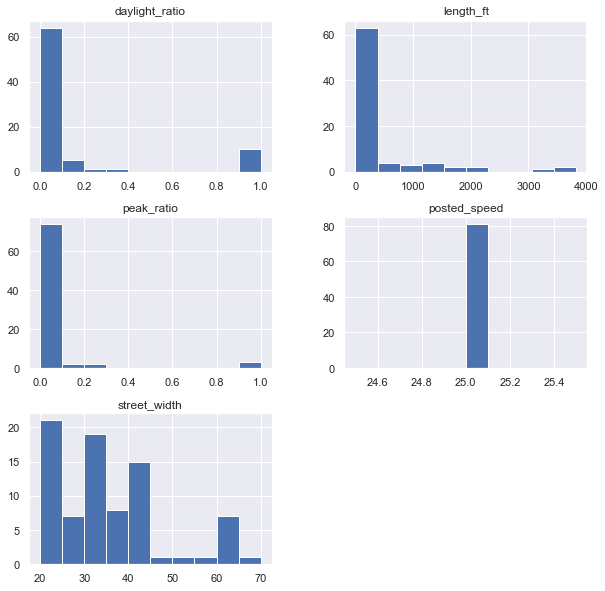

In [32]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 0][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio', 'length_ft' ]].hist(figsize=(10,10))
plt.show()

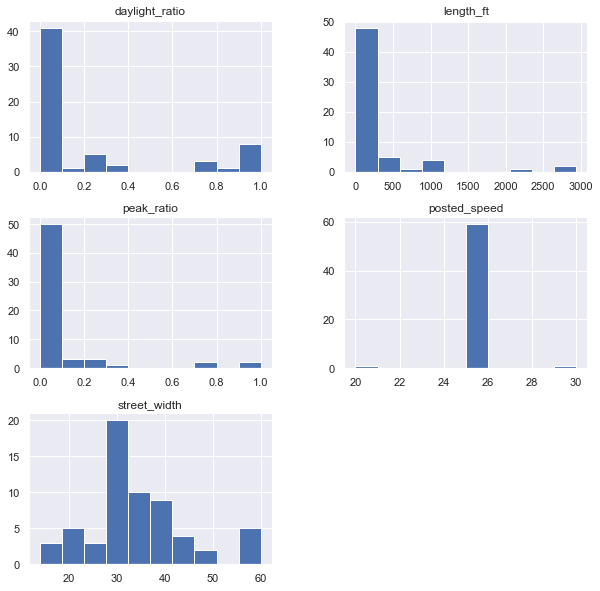

In [33]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 1][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio', 'length_ft' ]].hist(figsize=(10,10))
plt.show()

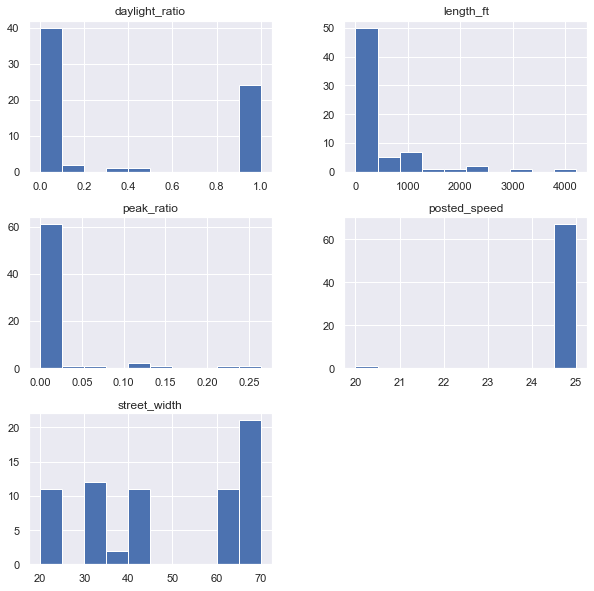

In [34]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 2][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio', 'length_ft' ]].hist(figsize=(10,10))
plt.show()

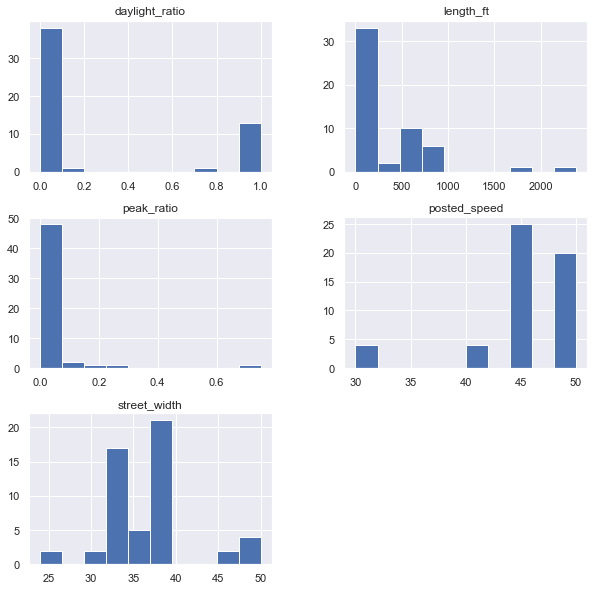

In [35]:
# # visualzing the clusters for Numerical features
df_511_target_geo_cluster[df_511_target_geo_cluster.cluster == 3][['posted_speed', 'street_width', 'daylight_ratio', 'peak_ratio', 'length_ft' ]].hist(figsize=(10,10))
plt.show()

##### Visualizing categorical features distribution across clusters

In [36]:
df_511_target_geo_cluster.groupby(['cluster', 'season']).size()

cluster  season
0        fall      20
         spring    37
         winter    24
1        fall       3
         spring     8
         summer    31
         winter    19
2        summer    68
3        fall      13
         spring     4
         summer    32
         winter     4
dtype: int64

In [37]:
df_511_target_geo_cluster.groupby(['cluster', 'roadway_type']).size()

cluster  roadway_type
0        1               78
         3                3
1        1               60
         3                1
2        1               66
         3                2
3        2               53
dtype: int64

In [38]:
df_511_target_geo_cluster.groupby(['cluster', 'create_time_weekend']).size()

cluster  create_time_weekend
0        0                      81
1        1                      61
2        0                      68
3        0                      49
         1                       4
dtype: int64